### Neural ODEs Background

The concept originates from Lagaris et al (1998), proposing a method to solve differential equations using neural networks. The neural network represents the solution and is trained to satisfy the differential equation's conditions.

#### Problem Setup

Consider a system of ordinary differential equations:

$ u' = f(u, t) $

with $ t \in [0, 1] $ and initial condition $u(0) = u_0 $

#### Neural Network Approximation

We approximate the solution using a neural network:

$ \text{NN}(t) \approx u(t) $ 

If $ \text{NN}(t)$  were the true solution, it would satisfy:

$  \text{NN}'(t) = f(\text{NN}(t), t)$ 

#### Loss Function

This leads to our initial loss function:

$  L(\omega) = \sum_i \left(\frac{d\text{NN}(t_i)}{dt} - f(\text{NN}(t_i), t_i)\right)^2 $ 

where:
- \(t_i\) can be chosen randomly or as a grid
- When minimized using gradient descent with automatic differentiation, we get $$\frac{d\text{NN}(t)}{dt} \approx f(\text{NN}(t_i), t_i)$$


#### Initial Condition Handling

To incorporate the initial condition, we add a term to the loss function:

$  L(\omega) = \sum_i \left(\frac{d\text{NN}(t_i)}{dt} - f(\text{NN}(t_i), t_i)\right)^2 + (\text{NN}(0) - u_0)^2 $ 

The parameters $\omega$ define the neural network NN that approximates $ u $. The problem reduces to finding weights that minimize this loss function.


### ODE Example

#### Problem Statement
Let's look at the ODE:

$$\frac{du}{dt} = \cos 2\pi t$$

Initial condition:

$$u(0) = 1$$

The exact solution:

$$u(t) = \frac{1}{2\pi}\sin 2\pi t + 1$$

#### Neural Network Implementation

The neural network should approximate this solution. Following Lagaris et al (1998), we define:

$$NN(t) \approx u(t)$$

#### Loss Function
The loss function combines two terms:

1. The differential equation constraint:
$$L_{DE}(\omega) = \sum_i \left(\frac{dNN(t_i)}{dt} - \cos(2\pi t_i)\right)^2$$

2. The initial condition constraint:
$$L_{IC}(\omega) = (NN(0) - 1)^2$$

The total loss function is:
$$L(\omega) = L_{DE}(\omega) + L_{IC}(\omega)$$

where $\omega$ represents the neural network parameters that need to be optimized to minimize this loss function.


### Importing All nessesary libraries 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random 

#### Defining our Neural network 

In [27]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
NN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,209 (8.63 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

#### For this problem I will use ADAM optimizer 

In [17]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)





### Loss Functions

#### ODE Loss
The loss for the differential equation:

$$L_{ODE} = \frac{1}{n}\sum_{i=1}^n \left(\frac{dNN(t_i)}{dt} - \cos 2\pi t_i\right)^2$$

#### Initial Condition Loss
The loss for the initial condition:

$$L_{IC} = \frac{1}{n}\sum_{i=1}^n (NN(0) - 1)^2$$

#### Total Loss
The combined loss function:

$$L_{Total} = L_{ODE} + L_{IC}$$



In [18]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

#### Training

1.9204701
0.00021524212
0.00011529126
5.9849925e-05
3.2888885e-05
2.33087e-05


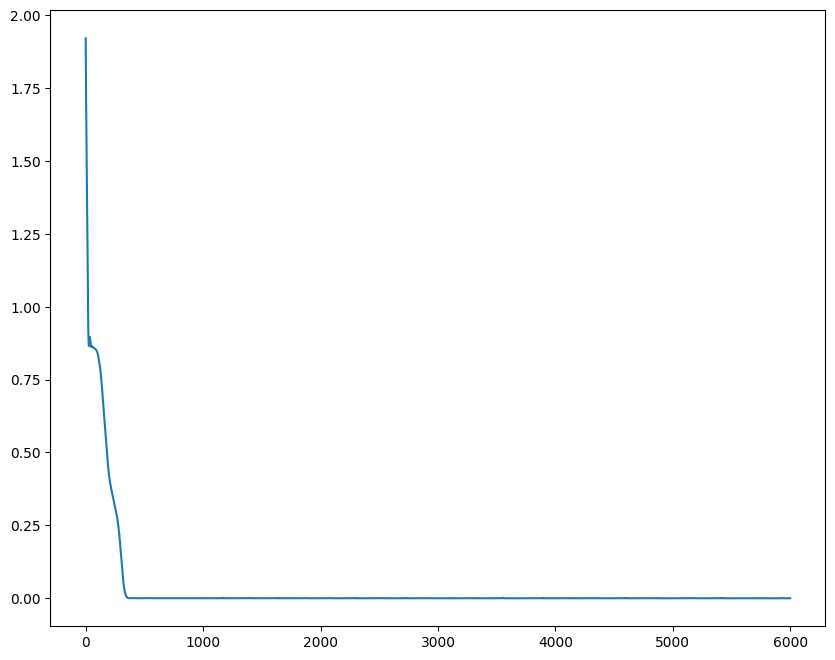

In [19]:
train_t = (np.array([0., 0.025, 0.475, 0.5, 0.525, 0.9, 0.95, 1., 1.05, 1.1, 1.4, 1.45, 1.5, 1.55, 1.6, 1.95, 2.])).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

##### Plot the results 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


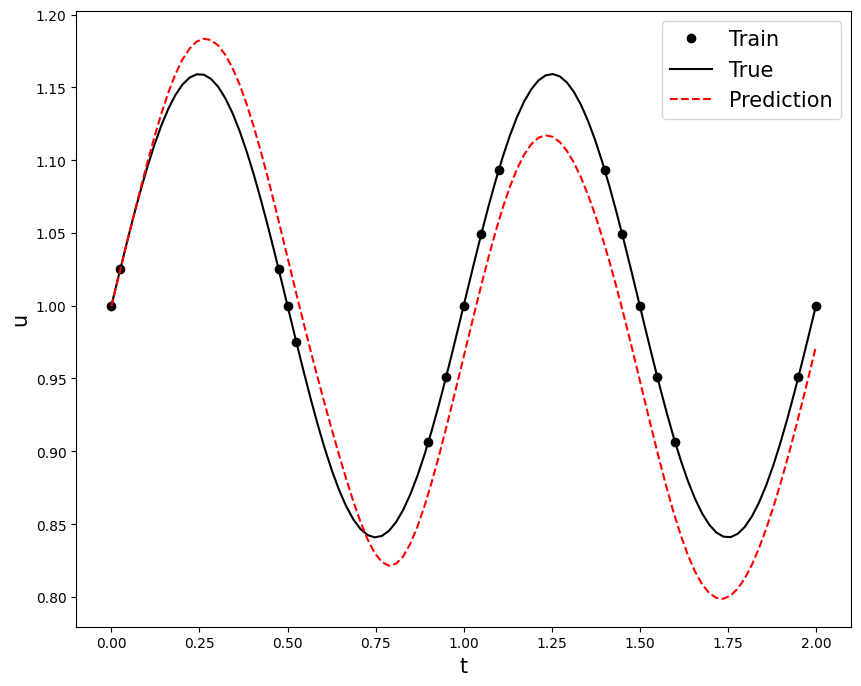

In [20]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()